# Detection In Images

From a high level point of view detecting something/anything in images
require an assumption about your dataset. 

You can either say that all of your images contain that which you want to
detect, or you can say that images in your dataset might contain that
which you want to detect.

If you are dealing with the first case, your problem is a regression problem in 
a continuous domain, since you are trying to locate the coordinates of your object in
image space. Formally speaking your codomain has infinitely many values.

If you are dealing with the second case, then your problem is a classification problem
that is you try to map your input values to a limited set of labels. 
Formally speaking the size of your codomain is limited to the number of labels you have.

In the case of detection in images, your input is an array of images, plus a set of features, you want to detect, and you want to obtain detected feature with the image as 
outuput.
For example, I have a stack of images containing statues in a museum, and I want to detect
which ones contain roman statutes and which ones contain egyptian statues.

If I know that all of the images contain these statues, then my problem is a regression problem. 
If I don't know that then my problem is classification problem.


Now all statistical phenomena requires a measurable representation. 

One of the things you have to do is to transform your problem into a domain that is
measurable and thus comparable.

Almost all image detection pipelines has roughly two main steps:

- Feature Description

- Feature Detection/Matching

You first describe what you want to detect in terms of a set of features,
then you examine other images to see if you can match your set of features with
another part in an image.

As you can guess, there is an enormous literature in both of these domains,
and we will be covering one feature descriptor combined with a technique for
feature matching to illustrate the general structure of an object detection pipeline and concepts.

We will start with a simple process called template matching and develop it.

Let's say you have a small part of an image and you want to detect similar
subregions in different images or in the same image, the simplest thing
you can do is to compare sum of pixel difference between your part and the rest
of the image.

Let's implement this.

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# some utility functions
def imshow(img: np.ndarray):
    if len(img.shape) < 3:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.plot()
    
def im2show(im1, im2):
    f, axs = plt.subplots(1,2,figsize=(15,15))
    fig = plt.figure()
    if len(im1.shape) < 3:
        axs[0].imshow(im1, cmap="gray")
        axs[1].imshow(im2, cmap="gray")
    else:
        axs[0].imshow(im1)
        axs[1].imshow(im2)
    plt.tight_layout()
    
def draw_bbox(im, bbox):
    rect = patches.Rectangle
    fig,ax = plt.subplots(1)
    # Display the image
    if len(im.shape) < 3:
        ax.imshow(im, cmap="gray")
    else:
        ax.imshow(im, figsize=(30, 25))
    # Create a Rectangle patch
    x,y,width, height = bbox
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.plot()

In [3]:
def match_region_image(region: np.ndarray, image: np.ndarray):
    "match region in image"
    min_diff_val = float('inf')
    best_positions = {}
    region_col_nb = region.shape[1]
    region_row_nb = region.shape[0]
    best_positions = {}
    for r in range(image.shape[0] - region_row_nb+1):
        for c in range(image.shape[1] - region_col_nb+1):
            imregion = image[r:region_row_nb+r, c:region_col_nb+c]
            rediff = np.abs(imregion - region).sum()
            if rediff < min_diff_val:
                min_diff_val = rediff
                best_positions["r"] = r
                best_positions["c"] = c
                best_positions["diff"] = rediff
    # extract from image best position
    row, col = best_positions["r"], best_positions["c"]
    imregion = image[row:region_row_nb+row, col:region_col_nb+col]
    return imregion, best_positions

Let's try our function using two different but similar images.

In [4]:
im1 = ImageOps.grayscale(Image.open("image/im1.jpg"))
im2 = ImageOps.grayscale(Image.open("image/im2.jpg"))
im1arr = np.array(im1)
im2arr = np.array(im2)
imregion = im1arr[35:60, 55:95].copy()
im2n = im2.resize(im1.size)

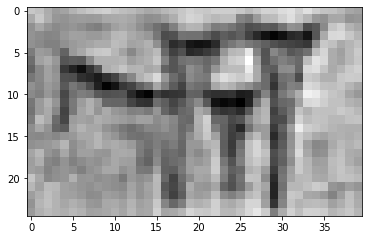

In [5]:
imshow(imregion)

In [6]:
# Now let's create an image pyramid for second image.
# a stack of same image in different resolutions
def flexible_roi(im: Image, region: np.ndarray, fn):
    "flexible region of interest extraction"
    col, row = im.size
    aspect_ratio = col / row # col / row
    sizes = []
    # for wscale in [0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6]:
    for wscale in [1.0, 1.2]:
        new_col = int(col * wscale)
        new_row = int(new_col / aspect_ratio)
        sizes.append((new_col, new_row))
        
    # creating resolution stack
    pyramid = [np.array(im.resize(size)) for size in sizes]

    minout_diff = float("inf")
    min_region = None
    min_region_info = None
    min_image = None

    for pyramid_image in pyramid:
        outregion, out_info = fn(region=imregion, image=pyramid_image)
        outdiff = out_info["diff"]
        if outdiff < minout_diff:
            min_region = outregion
            min_region_info = out_info
            minout_diff = outdiff
            min_image = pyramid_image
    return min_region_info, min_region, min_image

min_region_info, min_region, min_image = flexible_roi(im2n, imregion, fn=match_region_image)

In [7]:
print(min_region_info)
print(min_image.shape)
print(im2n.size)

{'r': 215, 'c': 410, 'diff': 47302}
(763, 894)
(745, 636)


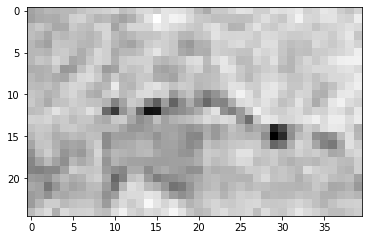

In [9]:
imshow(min_region)

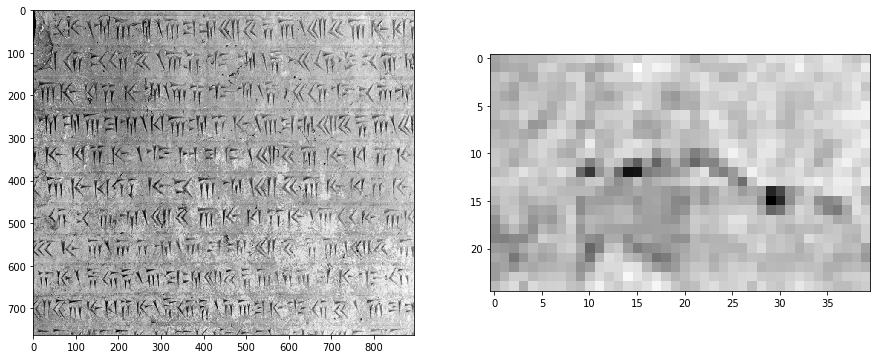

<Figure size 432x288 with 0 Axes>

In [10]:
im2show(min_image, min_region)

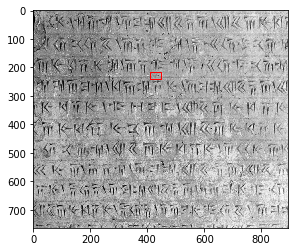

In [11]:
# Min_region in min_image
min_bbox = min_region_info["c"], min_region_info["r"], imregion.shape[1], imregion.shape[0]

draw_bbox(min_image, min_bbox)

The key part in this algorithm was the section:
`rediff = np.abs(imregion - region).sum()` why ?
Because it provided us a metric for measuring how close we are to the 
finding the region. We compared regions based on their
pixel differences.

Can we compare them using a better metric ?
Yes we absolutely can.
And the way to do that is to represent the region in a different form.



In [12]:
# HOG implementation
from scipy import ndimage as nd

def gradient_x(im):
    return nd.sobel(im, axis=0, mode="constant")

def gradient_y(im):
    return nd.sobel(im, axis=1, mode="constant")

def gradient_magnitude(g_x, g_y):
    return np.hypot(g_x, g_y)

def gradient_direction(g_x, g_y):
    g_d = np.arctan(g_y / (g_x + 1e-8)) # +1e-8 to ensure non zero divison
    g_d = np.rad2deg(g_d)
    return g_d % 360

def gradient_mag_dir(im):
    gx, gy = gradient_x(im), gradient_y(im)
    return gradient_magnitude(gx, gy), gradient_direction(gx, gy)

def hog(img, bin_n=16):
    """Taken from opencv:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_svm/py_svm_opencv/py_svm_opencv.html?highlight=hog
    """
    mag, gdir = gradient_mag_dir(img)
    bins = np.int32(bin_n*gdir/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist
    
    
def pad_with_zeros(arr1, arr2):
    if arr1.size < arr2.size:
        arr1 = np.pad(arr1, pad_width=(0, arr2.size - arr1.size), 
                  mode="constant", constant_values=0)
        return arr1, arr2
    else:
        arr2 = np.pad(arr2, pad_width=(0, arr1.size - arr2.size), 
                  mode="constant", constant_values=0)
        return arr1, arr2

Now instead of computing the difference of pixels like the last time let's compute the
difference of hog features

In [13]:
def match_region_image_hog(region: np.ndarray, image: np.ndarray):
    "match region in image"
    min_diff_val = float('inf')
    best_positions = {}
    region_col_nb = region.shape[1]
    region_row_nb = region.shape[0]
    region_hog = hog(region)
    best_positions = {}
    for r in range(image.shape[0] - region_row_nb+1):
        for c in range(image.shape[1] - region_col_nb+1):
            imregion = image[r:region_row_nb+r, c:region_col_nb+c]
            im_hist = hog(imregion)
            im_hist, region_hog = pad_with_zeros(im_hist, region_hog)
            rediff = np.hypot(im_hist, region_hog)
            renorm = np.linalg.norm(rediff)
            if renorm < min_diff_val:
                min_diff_val = renorm
                best_positions["r"] = r
                best_positions["c"] = c
                best_positions["diff"] = renorm
    # extract from image best position
    row, col = best_positions["r"], best_positions["c"]
    imregion = image[row:region_row_nb+row, col:region_col_nb+col]
    return imregion, best_positions

In [14]:
min_region_info2, min_region2, min_image2 = flexible_roi(im1, 
                                                         imregion, 
                                                         fn=match_region_image_hog)


In [272]:
print(min_region_info2)

{'r': 293, 'c': 551, 'diff': 14499.621994820798}


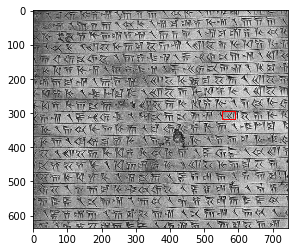

In [277]:
min_bbox2 = min_region_info2["c"], min_region_info2["r"], imregion.shape[1], imregion.shape[0]

draw_bbox(min_image2, min_bbox2)

Most of what we had seen so far has an equivalent in already established libraries.

Let's see some of their interesting functionality.

In [24]:
# Template matching with opencv
import cv2

img_rgb = cv2.imread('image/im1.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = imregion.copy()
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.5
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)


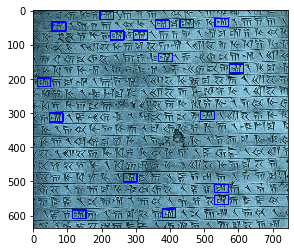

In [25]:
imshow(img_rgb)

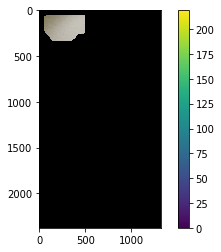

(<matplotlib.image.AxesImage at 0x7f9a71f8ec50>,
 None)

In [333]:
# segmentation of background from foreground

img = Image.open('image/greekstat.jpg')

mask = ImageOps.grayscale(Image.open('image/greekstat.jpg'))
mask = mask.resize(img.size)

img = np.array(img)
mask = np.array(mask)
mask[0:500, 20:50] = 0
mask[150:200, 600: 700] = 255
mask[mask != 255] = 0
Image.fromarray(mask).show()


bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img),plt.colorbar(),plt.show()

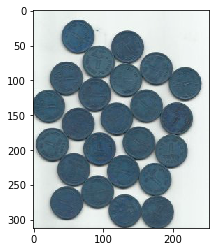

In [26]:
# segmentation of objects
img = cv2.imread('image/coins.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
imshow(img)

In [27]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


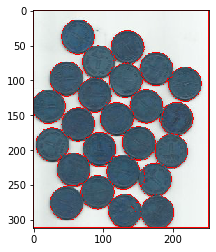

In [28]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

imshow(img)

In [29]:
# And of course feature detection and pattern matching

img1 = cv2.imread("image/im1.jpg", 0)
img2 = cv2.imread("image/im2.jpg", 0)

# Initiate SIFT detector
orb = cv2.ORB_create()
#orb = cv2.FastFeatureDetector()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.


In [30]:
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp1, des2 = orb.detectAndCompute(img2, None)

In [34]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)

im3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)

Image.fromarray(im3).show()